# CutMix

## 0. Paper

### Info
* Title: CutMix _ Regularization Strategy to Train Strong Classifiers with Localizable Features
* Author: Sangdoo Yun
* Task: Image Classification, Data Augmentation
* Link: https://arxiv.org/abs/1905.04899


### Features
* Dataset: CIFAR-10

### Reference
* https://github.com/clovaai/CutMix-PyTorch
* https://github.com/ildoonet/cutmix

## 1. Setting

In [1]:
# Libraries
import os
import sys
import time
from glob import glob

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from PIL import Image

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torchsummary import torchsummary

In [2]:
CONFIG = {
    'lr': 0.1,
    'momentum': 0.9,
    'weight_decay': 1e-4,
    'beta': 1.0,
    'cutmix_prob': 0.5,
    'batch_size': 128,
    'epoch_size': 200,
    'base_dir': '/content/drive/Shared drives/Yoon/Project/Doing/Deep Learning Paper Implementation',
}

## 2. Data

In [ ]:
def random_bbx(H, W, lmbd):
    cut_ratio = np.sqrt(1 - lmbd)
    cut_w = np.int(W * cut_ratio)
    cut_h = np.int(H * cut_ratio)

    cx = np.random.randint(W)
    cy = np.random.randint(H)

    bbx1 = np.clip(cx - cut_w // 2, 0, W)
    bby1 = np.clip(cy - cut_h // 2, 0, H)
    bbx2 = np.clip(cx + cut_w // 2, 0, W)
    bby2 = np.clip(cy + cut_h // 2, 0, H)
    return bbx1, bby1, bbx2, bby2


def cutmix(inputs, targets):
    p = np.random.rand()
    if p < CONFIG['cutmix_prob']:
        b, c, h, w = inputs.size()
        lmbd = np.random.beta(CONFIG['beta'], CONFIG['beta'])
        random_idx = np.random.permutation(b)
        targets_a, targets_b = targets, targets[random_idx]
        bbx1, bby1, bbx2, bby2 = random_bbx(h, w, lmbd)
        inputs[:, :, bbx1:bbx2, bby1:bby2] = inputs[random_idx, :, bbx1:bbx2, bby1:bby2]
        lmbd = 1 - ((bbx2 - bbx1) * (bby2 - bby1) / (w * h))
        targets = lmbd * targets_a + (1 - lmbd) * targets_b
    return inputs, targets

In [3]:
def create_dataloader(batch_size):
    train_transform = transforms.Compose([
        transforms.RandomCrop(32, padding=4),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2439, 0.2616)),
    ])

    test_transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2439, 0.2616)),
    ])

    target_transform = transforms.Compose([
        lambda x: torch.tensor(x),
        lambda x: F.one_hot(x, 10),
    ])

    train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=train_transform, target_transform=target_transform)
    test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=test_transform)
    train_dataset, val_dataset = torch.utils.data.random_split(train_dataset, [45000, 5000])

    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    
    return train_loader, val_loader, test_loader

In [4]:
train_loader, val_loader, test_loader = create_dataloader(CONFIG['batch_size'])
inputs, targets = next(iter(train_loader))
inputs.size(), targets.size()

Files already downloaded and verified
Files already downloaded and verified


(torch.Size([128, 3, 32, 32]), torch.Size([128, 10]))

In [14]:
inputs_cutmix, targets_cutmix = cutmix(inputs, targets)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


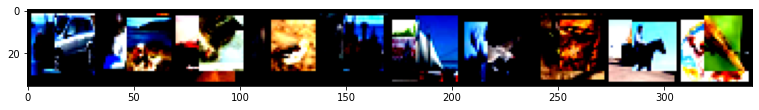

In [17]:
plt.figure(figsize=(13, 7))
plt.imshow(torchvision.utils.make_grid(inputs_cutmix[:10], nrow=10).permute(1, 2, 0))
plt.show()

In [15]:
targets_cutmix

tensor([[0.0000, 0.5332, 0.0000,  ..., 0.0000, 0.4668, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.4668, 0.0000],
        ...,
        [0.0000, 0.0000, 0.4668,  ..., 0.0000, 0.5332, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 1.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 1.0000]])

## 3. Model

In [5]:
class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, in_C, C, stride):
        super(Bottleneck, self).__init__()
        out_C = self.expansion * C
        self.shortcut = nn.Sequential()
        if stride > 1 or in_C != out_C:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_C, out_C, kernel_size=1, stride=stride, padding=0, bias=False),
                nn.BatchNorm2d(out_C)
            )
        
        self.conv1 = nn.Conv2d(in_C, C, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(C)
        self.conv2 = nn.Conv2d(C, C, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(C)
        self.conv3 = nn.Conv2d(C, out_C, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(out_C)
        self.relu = nn.ReLU(inplace=True)
    
    def forward(self, x):
        shortcut = self.shortcut(x)
        x = self.relu(self.bn1(self.conv1(x)))
        x = self.relu(self.bn2(self.conv2(x)))
        x = self.bn3(self.conv3(x))
        x += shortcut
        x = self.relu(x)
        return x


class ResNet(nn.Module):
    def __init__(self, C, n_classes):
        super(ResNet, self).__init__()
        self.in_C = C[0]
        self.stem = nn.Sequential(
            nn.Conv2d(3, self.in_C, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(self.in_C),
            nn.ReLU()
        )

        self.layer1 = self._make_layer(C[0], 1, 4)
        self.layer2 = self._make_layer(C[1], 2, 4)
        self.layer3 = self._make_layer(C[2], 2, 4)
        self.layer4 = self._make_layer(C[3], 2, 4)
        self.classifier = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Flatten(),
            nn.Linear(self.in_C, n_classes)
        )

    
    def _make_layer(self, C, stride, n_blocks):
        layers= []
        strides = [stride] + [1] * (n_blocks - 1)
        for st in strides:
            layers.append(Bottleneck(self.in_C, C, st))
            self.in_C = C * Bottleneck.expansion
        return nn.Sequential(*layers)
    
    def forward(self, x):
        x = self.stem(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.classifier(x)
        return x


def ResNet50():
    C = [16, 32, 64, 128]
    return ResNet(C, 10)


class CutmixCrossEntropyLoss(nn.Module):
    def __init__(self):
        super(CutmixCrossEntropyLoss, self).__init__()
    
    def forward(self, inputs, targets):
        if len(targets.size()) == 1:
            targets = F.one_hot(targets, num_classes=inputs.size(-1))
        probs = F.log_softmax(inputs, dim=-1)
        return torch.mean(torch.sum(-targets * probs, dim=1))


def accuracy(outputs, targets):
    if len(targets.size()) > 1:
        _, targets = targets.max(1)
    _, pred = outputs.max(1)
    acc = pred.eq(targets).float().mean()
    return acc

## 4. Experiment

In [6]:
class AverageMeter(object):
    def __init__(self, name):
        self.name = name
        self.reset()

    def reset(self):
        self.sum = 0
        self.count = 0
        self.avg = 0

    def update(self, val, n=1):
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

    def __str__(self):
        fmtstr = f'{self.name:10s} {self.avg:.3f}'
        return fmtstr


class ProgressMeter(object):
    def __init__(self, meters, loader_length, prefix=""):
        self.meters = [AverageMeter(i) for i in meters]
        self.loader_length = loader_length
        self.prefix = prefix
    
    def reset(self):
        for m in self.meters:
            m.reset()
    
    def update(self, values, n=1):
        for m, v in zip(self.meters, values):
            m.update(v, n)
            self.__setattr__(m.name, m.avg)

    def display(self, batch_idx, postfix=""):
        batch_info = f'[{batch_idx+1:03d}/{self.loader_length:03d}]'
        msg = [self.prefix + ' ' + batch_info]
        msg += [str(meter) for meter in self.meters]
        msg = ' | '.join(msg)

        sys.stdout.write('\r')
        sys.stdout.write(msg + postfix)
        sys.stdout.flush()

In [8]:
class Trainer(object):
    def __init__(self, model, criterion, optimizer, scheduler, use_cutmix):
        self.model = model
        self.criterion = criterion
        self.optimizer = optimizer
        self.scheduler = scheduler
        self.use_cutmix = use_cutmix
        self.best_epoch, self.best_acc = 0, 0
        

    def train(self, train_loader, epoch):
        progress = ProgressMeter(["train_loss"], len(train_loader), prefix=f'EPOCH {epoch:03d}')
        self.model.train()

        start_time = time.time()
        for idx, (inputs, targets) in enumerate(train_loader):
            inputs, targets = inputs.cuda(), targets.cuda()
            if self.use_cutmix:
                inputs, targets = cutmix(inputs, targets)
            outputs = self.model(inputs)
            loss = self.criterion(outputs, targets)

            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()

            loss = loss.item()
            progress.update([loss], n=inputs.size(0))
            if idx % 20 == 0:
                progress.display(idx+1)

        self.scheduler.step()
        finish_time = time.time()
        epoch_time = finish_time - start_time
        progress.display(idx, f' | {epoch_time:.0f}s' + '\n')

    
    def validate(self, val_loader, epoch):
        progress = ProgressMeter(["val_loss", "val_acc"], len(val_loader), prefix=f'VALID {epoch:03d}')
        self.model.eval()

        with torch.no_grad():
            for idx, (inputs, targets) in enumerate(val_loader):
                inputs, targets = inputs.cuda(), targets.cuda()
                outputs = self.model(inputs)
                loss = self.criterion(outputs, targets)
                acc = accuracy(outputs, targets)
                progress.update([loss, acc], n=inputs.size(0))

            if progress.val_acc > self.best_acc:
                ckpt = {
                    'best_epoch': self.best_epoch,
                    'best_acc': self.best_acc,
                    'model_state_dict': self.model.state_dict()
                }
                torch.save(ckpt, 'ckpt.pt')
                self.best_epoch = epoch
                self.best_acc = progress.val_acc
            
            progress.display(idx, '\n')

    
    def test(self, test_loader):
        progress = ProgressMeter(["test_loss", "test_acc"], len(test_loader), prefix=f'TEST')
        ckpt = torch.load('ckpt.pt')
        self.model.load_state_dict(ckpt['model_state_dict'])
        self.model.eval()

        with torch.no_grad():
            for idx, (inputs, targets) in enumerate(test_loader):
                inputs, targets = inputs.cuda(), targets.cuda()
                outputs = self.model(inputs)
                loss = self.criterion(outputs, targets)
                acc = accuracy(outputs, targets)
                progress.update([loss, acc], n=inputs.size(0))

            progress.display(idx, '\n')

In [9]:
model = ResNet50().cuda()
criterion = CutmixCrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), CONFIG['lr'], momentum=CONFIG['momentum'], weight_decay=CONFIG['weight_decay'], nesterov=True)
scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lambda ep: CONFIG['lr'] * (0.1 ** (ep // (CONFIG['epoch_size'] * 0.5))) * (0.1 ** (ep // (CONFIG['epoch_size'] * 0.75))))

trainer = Trainer(model, criterion, optimizer, scheduler, use_cutmix=True)

In [10]:
for ep in range(CONFIG['epoch_size']):
    print('=' * 65)
    trainer.train(train_loader, ep)
    trainer.validate(val_loader, ep)

EPOCH 000 [352/352] | train_loss 1.953 | 35s
VALID 000 [040/040] | val_loss   1.605 | val_acc    0.408
EPOCH 001 [352/352] | train_loss 1.700 | 35s
VALID 001 [040/040] | val_loss   1.340 | val_acc    0.521
EPOCH 002 [352/352] | train_loss 1.516 | 34s
VALID 002 [040/040] | val_loss   1.307 | val_acc    0.548
EPOCH 003 [352/352] | train_loss 1.428 | 34s
VALID 003 [040/040] | val_loss   1.141 | val_acc    0.612
EPOCH 004 [352/352] | train_loss 1.335 | 34s
VALID 004 [040/040] | val_loss   1.020 | val_acc    0.645
EPOCH 005 [352/352] | train_loss 1.273 | 34s
VALID 005 [040/040] | val_loss   0.888 | val_acc    0.696
EPOCH 006 [352/352] | train_loss 1.203 | 34s
VALID 006 [040/040] | val_loss   0.854 | val_acc    0.715
EPOCH 007 [352/352] | train_loss 1.114 | 34s
VALID 007 [040/040] | val_loss   0.770 | val_acc    0.739
EPOCH 008 [352/352] | train_loss 1.098 | 34s
VALID 008 [040/040] | val_loss   0.755 | val_acc    0.750
EPOCH 009 [352/352] | train_loss 1.072 | 34s
VALID 009 [040/040] | val_lo

In [11]:
trainer.test(test_loader)

TEST [079/079] | test_loss  0.272 | test_acc   0.917
